In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc,precision_recall_curve,roc_curve,confusion_matrix
import os,sys
import pickle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import random
import seaborn as sns
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d

import torch.optim as optim
from sklearn.metrics import accuracy_score,recall_score,f1_score

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)


## The Network

In [36]:
def compute_conv_dim(dim_size,kernel_size,padding,stride):
    return int((dim_size - kernel_size + 2 * padding) / stride + 1)
compute_conv_dim(34,2,0,1)

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
          nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
          if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
          nn.init.constant_(m.weight.data, 1)
          nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
          nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
          if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)

In [38]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Denselayer
        self.L_in = Linear(in_features=529, # 528 if binding_score None, else 529
                            out_features= 264)

        self.batchnorm1 = nn.BatchNorm1d(264)
        self.drop_out1 = nn.Dropout(p=0.4)

        self.L_2 = Linear(in_features = 793,
                            out_features = 396)

        self.batchnorm2 = nn.BatchNorm1d(396)
        self.drop_out2 = nn.Dropout(p=0.4)

        self.L_3 = Linear(in_features = 1189,
                            out_features = 594)

        self.batchnorm3 = nn.BatchNorm1d(594)
        self.drop_out3 = nn.Dropout(p=0.4)

        self.L_out = Linear(in_features = 594,
                            out_features = 2)
    
    def forward(self, peptide, HLA, binding_score=None): # x.size() = [batch, channel, height, width]

        # Encoding the peptide
        # peptide = self.conv1_peptide(peptide)
        # peptide = self.BatchNorm_conv1_peptides(peptide)
        # peptide = relu(peptide)
        # peptide = self.conv2_peptide(peptide)
        # peptide = self.BatchNorm_conv2_peptides(peptide)
        # peptide = relu(peptide)
        # peptide = self.maxpool1_peptide(peptide)
        peptide = torch.flatten(peptide,start_dim=1)

        # Encoding the HLA
        # HLA = self.conv1_HLA(HLA)
        # HLA = self.BatchNorm_conv1_HLA(HLA)
        # HLA = relu(HLA)
        # HLA = self.maxpool1_HLA(HLA)
        # HLA = self.conv2_HLA(HLA)
        # HLA = self.BatchNorm_conv2_HLA(HLA)
        # HLA = relu(HLA)
        # HLA = self.maxpool2_HLA(HLA)
        HLA = torch.flatten(HLA,start_dim=1)

        if binding_score is None:
            combined_input = torch.cat((peptide, HLA), 1)
      
        else:
            combined_input = torch.cat((peptide, HLA,binding_score), 1)

        x = self.L_in(combined_input)
        x = relu(x)
        x = self.batchnorm1(x)
        x = self.drop_out1(x)

        x_resnet1 = torch.cat((x, combined_input), 1)
        x = self.L_2(x_resnet1)
        x = relu(x)
        x = self.batchnorm2(x)
        x = self.drop_out2(x)

        x_resnet2 = torch.cat((x, x_resnet1), 1)
        x = self.L_3(x_resnet2)
        x = relu(x)
        x = self.batchnorm3(x)
        x = self.drop_out3(x)
        x = self.L_out(x)
        x = relu(x)
        return softmax(x, dim=1)

net = Net()
net.apply(initialize_weights)
print(net)

Net(
  (L_in): Linear(in_features=529, out_features=264, bias=True)
  (batchnorm1): BatchNorm1d(264, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_out1): Dropout(p=0.4, inplace=False)
  (L_2): Linear(in_features=793, out_features=396, bias=True)
  (batchnorm2): BatchNorm1d(396, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_out2): Dropout(p=0.4, inplace=False)
  (L_3): Linear(in_features=1189, out_features=594, bias=True)
  (batchnorm3): BatchNorm1d(594, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_out3): Dropout(p=0.4, inplace=False)
  (L_out): Linear(in_features=594, out_features=2, bias=True)
)


In [39]:
peptide_random = np.random.normal(0,1, (10, 1, 10, 12)).astype('float32')
peptide_random = Variable(torch.from_numpy(peptide_random))
HLA_random = np.random.normal(0,1, (10, 1, 34, 12)).astype('float32')
HLA_random = Variable(torch.from_numpy(HLA_random))
binding_random = np.random.normal(0,1, (10, 1)).astype('float32')
binding_random = Variable(torch.from_numpy(binding_random))

output = net(peptide_random,HLA_random, binding_random)
output

tensor([[0.3930, 0.6070],
        [0.4541, 0.5459],
        [0.5000, 0.5000],
        [0.9714, 0.0286],
        [0.9744, 0.0256],
        [0.5000, 0.5000],
        [0.0883, 0.9117],
        [0.5000, 0.5000],
        [0.5125, 0.4875],
        [0.2605, 0.7395]], grad_fn=<SoftmaxBackward0>)

## Functions for loading data

In [40]:

def encode_peptide_aaindex(aa_seq,aaindex_PCA,row):
    aa_seq = list(aa_seq.upper())
    encoded_aa_seq = []
    PCs = aaindex_PCA.shape[1]
    for aa in aa_seq:
        if aa == "X" or aa == "-":
            encoded_aa_seq.append(np.array([0 for x in range(PCs)]))
        else:
            try:
                encoded_aa_seq.append(aaindex_PCA.loc[aa].to_numpy())
            except KeyError:
                print(row)
                sys.exit(1)
    return np.array(encoded_aa_seq)

def encode_dataset(df,aaindex_PCA,HLA_dict,peptide_len,padding="right"):
    encoded_peptides = []
    encoded_labels = []
    encoded_hlas = []
    encoded_binding_scores = []
    for i,row in df.iterrows():
        peptide = row["peptide"]
        HLA = HLA_dict[row["HLA_allele"].replace(":","")]
        encoded_peptide = encode_peptide_aaindex(peptide,aaindex_PCA,row)
        binding_score = row['binding_score']


        # Adding padding
        if len(encoded_peptide) < peptide_len:
            n_added = peptide_len-len(encoded_peptide)
            if padding == "right":
                encoded_peptide = np.pad(encoded_peptide, ((0, 1), (0, 0)), 'constant')
            elif padding == "left":
                encoded_peptide = np.pad(encoded_peptide, ((1, 0), (0, 0)), 'constant')
            elif padding == "random":
                top_pad = random.choice([0,1])
                bot_pad = 1-top_pad
                encoded_peptide = np.pad(encoded_peptide, ((top_pad, bot_pad), (0, 0)), 'constant')


        encoded_HLA = encode_peptide_aaindex(HLA,aaindex_PCA,row)
        encoded_label = min(1,row["positive_subjects"])
        encoded_peptides.append(encoded_peptide)
        encoded_hlas.append(encoded_HLA)
        encoded_labels.append(encoded_label)
        encoded_binding_scores.append(binding_score)
    
    encoded_peptides = np.array(encoded_peptides).astype('float32')
    encoded_hlas = np.array(encoded_hlas).astype('float32')
    encoded_labels = np.array(encoded_labels).astype('float32')
    encoded_binding_scores = np.array(encoded_binding_scores).astype('float32')
    return encoded_peptides, encoded_hlas, encoded_binding_scores, encoded_labels


## Functions for plotting model statistics

In [41]:
def plot_epochs(K, lst_train_acc, lst_val_acc): 
    plt.figure()
    for i in range(K):
        epoch = np.arange(len(lst_train_acc[i]))
        plt.plot(epoch, lst_train_acc[i], 'r', epoch, lst_val_acc[i], 'b')
    plt.title("Performance of {} fold CV".format(K))
    plt.legend(['Train Accuracy','Validation Accuracy'])
    plt.xlabel('epochs'), plt.ylabel('Acc')
    plt.show()


def calculate_avg_val_performance(K, N, lst_val_acc, lst_val_lab, lst_val_pred):
    """Calculate the generalization error

    Args:
        lst_val_acc (list of lists): list of lists containing validation accuracies for each fold
        lst_val_lab (list of lists): list of lists containing validation labels for each fold
        lst_val_pred (list of lists): list of lists containing validation predictions for each fold
        N (int): Total number of observations in data set
    """
    avg_recall = 0
    avg_accuracy = 0 
    avg_f1 = 0

    res = np.zeros((K,5))
    for i in range(K):
        best_epoch_model = np.argmax(lst_val_acc[i])
        n = len(lst_val_lab[i][best_epoch_model])
        accuracy = accuracy_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])
        recall = recall_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])
        f1 = f1_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])

        res[i][0] = best_epoch_model
        res[i][1] = n
        res[i][2] = accuracy
        res[i][3] = recall
        res[i][4] = f1

        avg_recall += (n/N) * recall
        avg_accuracy += (n/N) * accuracy
        avg_f1 += (n/N) * f1

    print(f"Best average results - Recall: {avg_recall} accuracy: {avg_accuracy} f1-score: {avg_f1}")
    return res

def k_fold_confusion_matrix(K, lst_val_acc, lst_val_lab, lst_val_pred):
    """Plot the overall confusion matrix for 5 fold CV

    Args:
        lst_val_acc (list of lists): list of lists containing validation accuracies for each fold
        lst_val_lab (list of lists): list of lists containing validation labels for each fold
        lst_val_pred (list of lists): list of lists containing validation predictions for each fold
    """
    all_labels = []
    all_predictions = []
    for i in range(K):
        best_epoch_model = np.argmax(lst_val_acc[i])
        all_labels.extend(lst_val_lab[i][best_epoch_model])
        all_predictions.extend(lst_val_pred[i][best_epoch_model])

    fig = plt.figure(figsize=(10,6))
    plt.title("Confusion matrix of best epoch for validation performance")
    conf_mat = confusion_matrix(all_labels,all_predictions)
    sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



def violin_one_fold(lst_val_acc, lst_val_lab, lst_val_pred, lst_val_prob):
    best_epoch_model = np.argmax(lst_val_acc)
    labels_best_epoch = lst_val_lab[best_epoch_model]
    predictions_best_epoch = lst_val_pred[best_epoch_model]
    probabilities_best_epoch = lst_val_prob[best_epoch_model]
    true_predictions = [x==y for x,y in zip(labels_best_epoch,predictions_best_epoch)]
    dataframe = pd.DataFrame()
    dataframe["Probs"] = probabilities_best_epoch
    dataframe["Predictions"] = predictions_best_epoch
    dataframe["Labels"] = labels_best_epoch
    dataframe["True"] = true_predictions    

    plt.figure(figsize=(10,6))
    ax = sns.violinplot(x="True", y="Probs", data=dataframe)
    plt.title("For the best epoch of the best fold - so only one model here!")
    plt.xlabel("Predicted label")
    plt.ylabel("Probability associated with label")
    plt.show()

    plt.figure(figsize=(10,6))
    ax = sns.boxplot(x="True", y="Probs", data=dataframe)
    plt.title("For the best epoch of the best fold - so only one model here!")
    plt.xlabel("Predicted label")
    plt.ylabel("Probability associated with label")
    plt.show()



def violin_best_fold(res_mtrx, lst_val_acc, lst_val_lab, lst_val_pred, lst_val_prob):
    """For the best fold, find the best epoch, and plot the violin plot

    Args:
        res_mtrx (matrix): result matrix from calculate_avg_performance
        lst_val_acc (list of lists): list of lists containing validation accuracies for each fold
        lst_val_lab (list of lists): list of lists containing validation labels for each fold
        lst_val_pred (list of lists): list of lists containing validation predictions for each fold
        lst_val_prob (list of lists): list of lists containing validation probabilities for each fold
    """
    best_fold = np.argmax(res_mtrx[:,2])
    best_epoch_model = np.argmax(lst_val_acc[best_fold])
    labels_best_epoch = lst_val_lab[best_fold][best_epoch_model]
    predictions_best_epoch = lst_val_pred[best_fold][best_epoch_model]
    probabilities_best_epoch = lst_val_prob[best_fold][best_epoch_model]
    true_predictions = [x==y for x,y in zip(labels_best_epoch,predictions_best_epoch)]
    dataframe = pd.DataFrame()
    dataframe["Probs"] = probabilities_best_epoch
    dataframe["Predictions"] = predictions_best_epoch
    dataframe["Labels"] = labels_best_epoch
    dataframe["True"] = true_predictions    

    plt.figure(figsize=(10,6))
    ax = sns.violinplot(x="True", y="Probs", data=dataframe)
    plt.title("For the best epoch of the best fold - so only one model here!")
    plt.xlabel("Predicted label")
    plt.ylabel("Probability associated with label")
    plt.show()

    plt.figure(figsize=(10,6))
    ax = sns.boxplot(x="True", y="Probs", data=dataframe)
    plt.title("For the best epoch of the best fold - so only one model here!")
    plt.xlabel("Predicted label")
    plt.ylabel("Probability associated with label")
    plt.show()

## Functions for training the models

In [42]:
def plot_learning_curve(train_accuracies,val_accuracies):
    epoch = np.arange(len(train_accuracies))
    plt.figure()
    plt.plot(epoch, train_accuracies, 'r', epoch, val_accuracies, 'b')
    plt.legend(['Train Accucary','Validation Accuracy'])
    plt.xlabel('epochs'), plt.ylabel('Acc')



def validation(model,device,valid_loaders,train_loaders):
    peptide_val_loader,HLA_val_loader,label_val_loader,binding_score_val_loader = valid_loaders
    peptide_train_loader,HLA_train_loader,label_train_loader,binding_score_train_loader = train_loaders
    model.eval()
    with torch.no_grad():
        all_train_targets = []
        all_predicted_train_labels = []
        for i in range(len((peptide_train_loader))):
            train_peptides = peptide_train_loader[i].to(device)
            train_HLA = HLA_train_loader[i].to(device)
            train_labels = label_train_loader[i].long().to(device)
            train_binding_scores = binding_score_train_loader[i].to(device)
            outputs = model(train_peptides,train_HLA,train_binding_scores)
            _,predicted_labels =  torch.max(outputs, 1)

            all_predicted_train_labels += predicted_labels.cpu().numpy().tolist()
            all_train_targets += train_labels.cpu().numpy().tolist()
        
        all_val_targets = []
        all_predicted_val_labels = []
        all_probabilities_val = []
        for j in range(len((peptide_val_loader))):
            val_peptides = peptide_val_loader[j].to(device)
            val_HLA = HLA_val_loader[j].to(device)
            val_labels = label_val_loader[j].long().to(device)
            val_binding_scores = binding_score_val_loader[j].to(device)
            outputs = model(val_peptides,val_HLA,val_binding_scores)
            probability,predicted_labels =  torch.max(outputs, 1)
            all_predicted_val_labels += predicted_labels.cpu().numpy().tolist()
            all_val_targets += val_labels.cpu().numpy().tolist()
            all_probabilities_val += probability.cpu().numpy().tolist()

    return all_train_targets,all_predicted_train_labels,all_val_targets,all_predicted_val_labels,all_probabilities_val


def train(model, device, epochs, train_loaders, valid_loaders):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-4)

    # Early stopping
    the_last_loss = 100
    patience = 4
    trigger_times = 0
    
    all_val_targets_pr_epoch = []
    all_val_predictions_pr_epoch = []
    all_val_probabilities_pr_epoch = []
    losses = []

    train_accuracies = []
    val_accuracies = []

    peptide_train_loader,HLA_train_loader,label_train_loader,binding_score_train_loader = train_loaders
        
    for epoch in range(epochs):
        model.train()
        current_loss = 0
        for train_batch_index in range(len((peptide_train_loader))):
            train_peptides = peptide_train_loader[train_batch_index].to(device)
            train_HLA = HLA_train_loader[train_batch_index].to(device)
            train_labels = label_train_loader[train_batch_index].long().to(device)
            train_binding_scores = binding_score_train_loader[train_batch_index].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            outputs = model(train_peptides,train_HLA,train_binding_scores)
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()
            current_loss += loss.item()
        losses.append(current_loss/len((peptide_train_loader)))

        all_train_targets,all_predicted_train_labels,all_val_targets,all_predicted_val_labels,all_probabilities_val = validation(model,device,valid_loaders,train_loaders)
    
        # Calculating the accuracies
        train_accuracies.append(accuracy_score(all_train_targets,all_predicted_train_labels))
        val_accuracies.append(accuracy_score(all_val_targets,all_predicted_val_labels))
        # Saving the predicitons for further validation
        all_val_targets_pr_epoch.append(all_val_targets)
        all_val_predictions_pr_epoch.append(all_predicted_val_labels)
        all_val_probabilities_pr_epoch.append(all_probabilities_val)

        if epoch % 10 == 0:
            print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (epoch+1, losses[-1], train_accuracies[-1], val_accuracies[-1]))
        

        # Early stopping
        the_current_loss = val_accuracies[-1]
        the_last_loss = 0 if len(val_accuracies) < 2 else val_accuracies[-2]

        # print('The current valdiation loss:', the_current_loss)

        if the_current_loss < the_last_loss:
            trigger_times += 1
            # print('trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping at epoch',epoch," with patience",patience)
                return model,train_accuracies,val_accuracies,all_val_targets_pr_epoch,all_val_predictions_pr_epoch,all_val_probabilities_pr_epoch

        else:
            # print('trigger times: 0')
            trigger_times = 0

    return model,train_accuracies,val_accuracies,all_val_targets_pr_epoch,all_val_predictions_pr_epoch,all_val_probabilities_pr_epoch

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device state:', device)


Device state: cpu


## Encoding entire data set

In [43]:
# Loading the databases
aaindex_PCA = pd.read_csv('../data/PCA_repr_aa.csv',index_col=0)
hla_database = pd.read_csv('../data/formatted_hla2paratope_MHC_pseudo.dat', sep=' ',index_col=0)
hla_dic = hla_database.to_dict("dict")["pseudo"]

all_data = pd.read_csv("../data/filtered_data_IEDB_4_tested_len_9_10_full_HLA_Multi_assay_w_binding_w_parts.csv")
all_data = all_data.sample(frac=1, random_state=1).reset_index(drop=True)

all_peptides_encoded,all_HLA_encoded,all_binding_scores_encoded,all_label_encoded = encode_dataset(all_data,aaindex_PCA,hla_dic,peptide_len=10,padding="right")

## 5-fold cross-validation loop

the val and train parts
[1, 2] [3, 4, 5, 6, 7, 8, 9]
Epoch  1 : Train Loss 0.682442 , Train acc 0.645669, Valid acc 0.647600
Epoch 11 : Train Loss 0.574981 , Train acc 0.700037, Valid acc 0.689020
Epoch 21 : Train Loss 0.553534 , Train acc 0.727409, Valid acc 0.696910
Epoch 31 : Train Loss 0.538174 , Train acc 0.763967, Valid acc 0.715319
Epoch 41 : Train Loss 0.522796 , Train acc 0.779528, Valid acc 0.711374
Early stopping at epoch 40  with patience 4


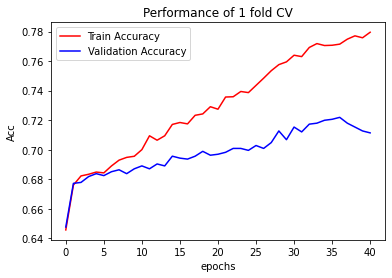

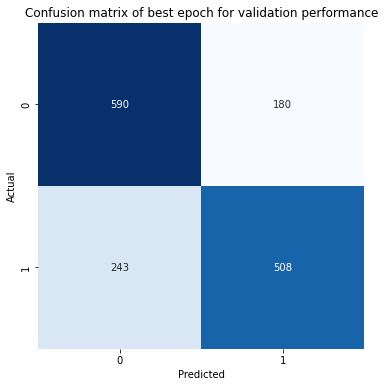

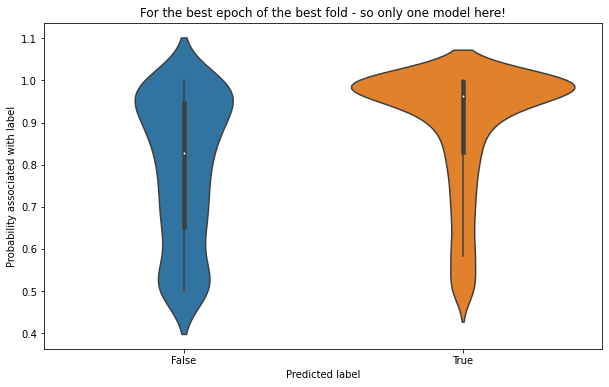

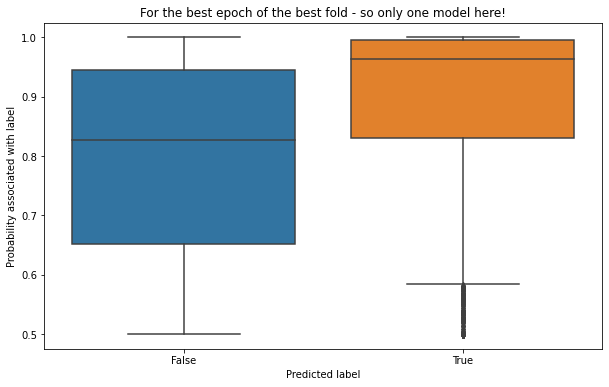

the val and train parts
[3, 4] [1, 2, 5, 6, 7, 8, 9]
Epoch  1 : Train Loss 0.645533 , Train acc 0.655011, Valid acc 0.659589
Epoch 11 : Train Loss 0.571854 , Train acc 0.708863, Valid acc 0.694758
Epoch 21 : Train Loss 0.548239 , Train acc 0.752431, Valid acc 0.704048
Epoch 31 : Train Loss 0.535015 , Train acc 0.767390, Valid acc 0.704048
Epoch 41 : Train Loss 0.520235 , Train acc 0.788332, Valid acc 0.708029
Epoch 51 : Train Loss 0.509833 , Train acc 0.805722, Valid acc 0.717983
Epoch 61 : Train Loss 0.499109 , Train acc 0.818624, Valid acc 0.720637
Epoch 71 : Train Loss 0.487935 , Train acc 0.827225, Valid acc 0.716656
Epoch 81 : Train Loss 0.480158 , Train acc 0.844054, Valid acc 0.721964
Epoch 91 : Train Loss 0.469809 , Train acc 0.850411, Valid acc 0.723291


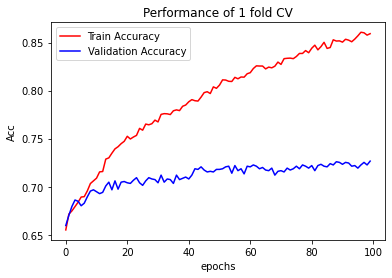

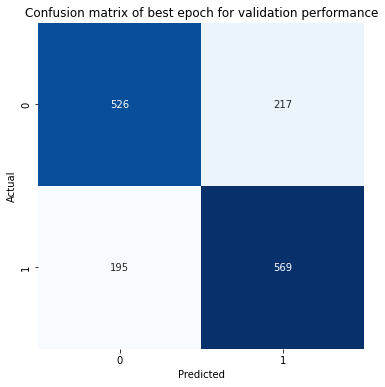

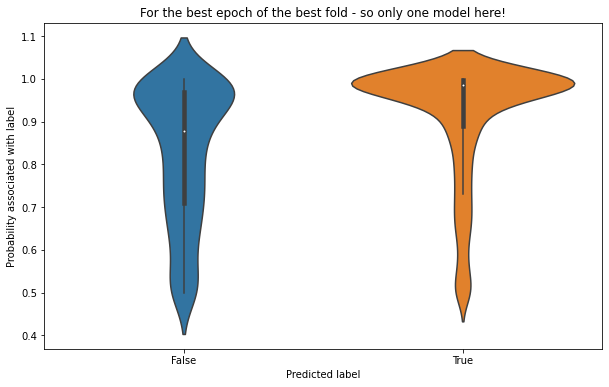

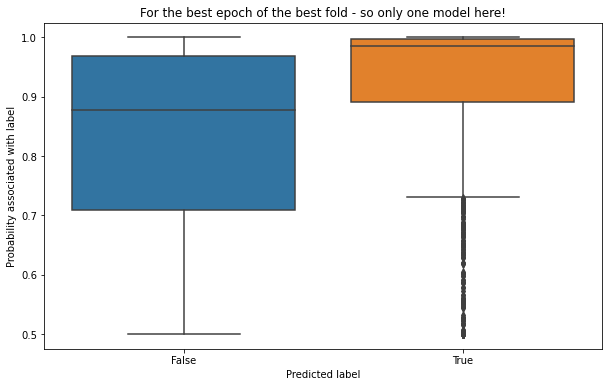

the val and train parts
[5, 6] [1, 2, 3, 4, 7, 8, 9]
Epoch  1 : Train Loss 0.662965 , Train acc 0.648618, Valid acc 0.649089
Early stopping at epoch 9  with patience 4


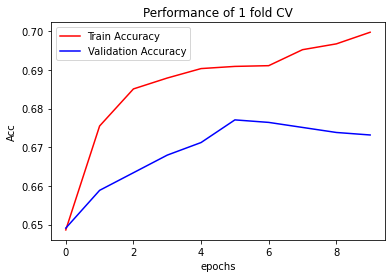

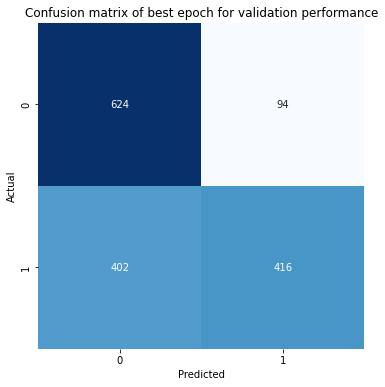

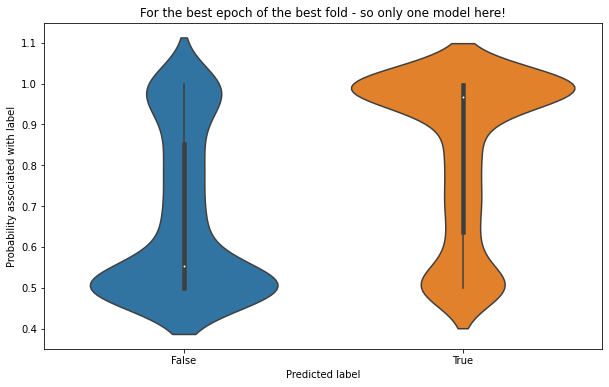

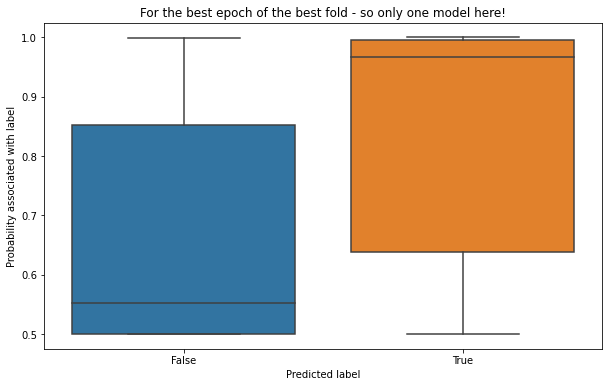

the val and train parts
[7, 8] [1, 2, 3, 4, 5, 6, 9]
Epoch  1 : Train Loss 0.647764 , Train acc 0.650038, Valid acc 0.646750
Epoch 11 : Train Loss 0.564393 , Train acc 0.705176, Valid acc 0.695995
Epoch 21 : Train Loss 0.549639 , Train acc 0.726182, Valid acc 0.704531
Epoch 31 : Train Loss 0.534974 , Train acc 0.749625, Valid acc 0.719632
Epoch 41 : Train Loss 0.520619 , Train acc 0.776819, Valid acc 0.720946
Epoch 51 : Train Loss 0.504186 , Train acc 0.796887, Valid acc 0.724228
Epoch 61 : Train Loss 0.495346 , Train acc 0.813391, Valid acc 0.731451
Epoch 71 : Train Loss 0.485201 , Train acc 0.829332, Valid acc 0.731451
Epoch 81 : Train Loss 0.474926 , Train acc 0.843961, Valid acc 0.727511
Epoch 91 : Train Loss 0.466615 , Train acc 0.853713, Valid acc 0.732764


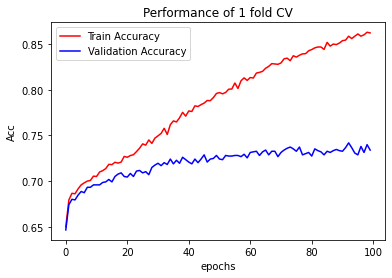

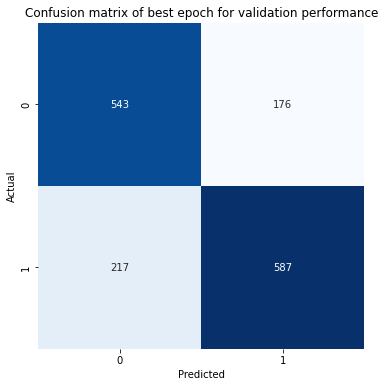

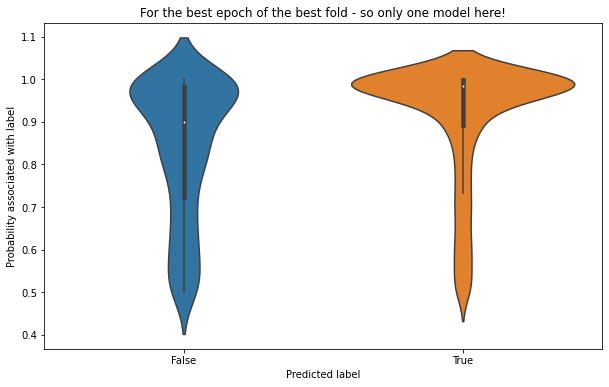

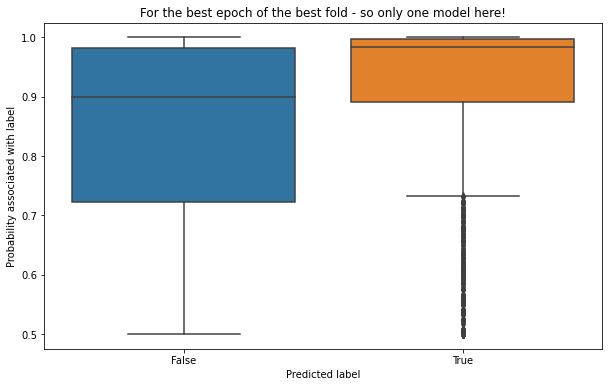

the val and train parts
[9] [1, 2, 3, 4, 5, 6, 7, 8]
Epoch  1 : Train Loss 0.651849 , Train acc 0.657631, Valid acc 0.641927
Epoch 11 : Train Loss 0.562399 , Train acc 0.707245, Valid acc 0.680990
Epoch 21 : Train Loss 0.545035 , Train acc 0.757023, Valid acc 0.726562
Epoch 31 : Train Loss 0.530801 , Train acc 0.771644, Valid acc 0.717448
Epoch 41 : Train Loss 0.518674 , Train acc 0.789552, Valid acc 0.697917
Epoch 51 : Train Loss 0.509340 , Train acc 0.802859, Valid acc 0.703125
Epoch 61 : Train Loss 0.496290 , Train acc 0.814851, Valid acc 0.705729
Epoch 71 : Train Loss 0.487217 , Train acc 0.830458, Valid acc 0.704427
Early stopping at epoch 75  with patience 4


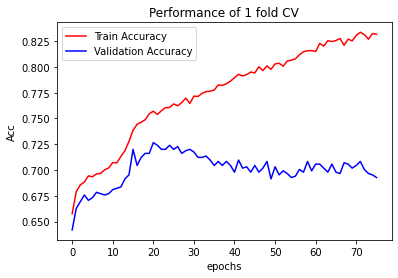

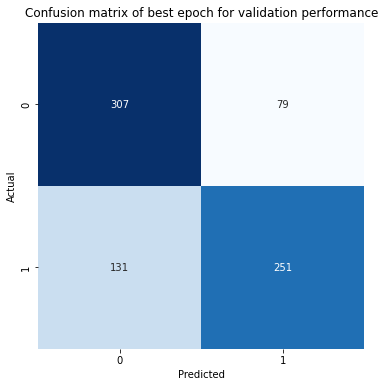

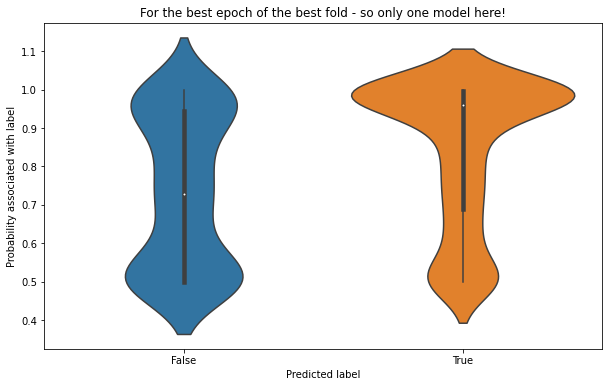

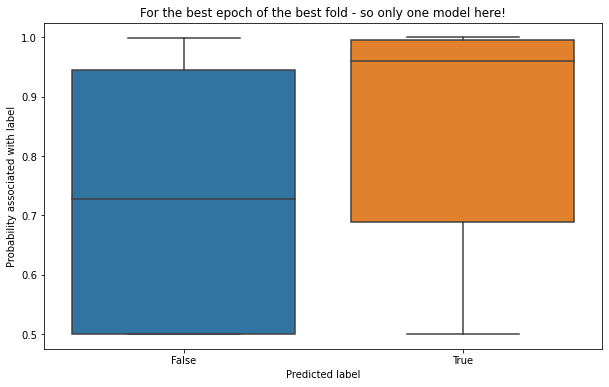

In [29]:
N = len(all_data)
K = 5
no_epoch = 100

testing = True
part_dict = {0:[0,1], 1:[2,3], 2:[4,5], 3:[6,7], 4:[8,9]}
part_dict_testing = {0:[1,2], 1:[3,4], 2:[5,6], 3:[7,8], 4:[9]}
partitions = [0,1,2,3,4,5,6,7,8,9]

batch_size = 100

lst_train_accuracies = []

lst_val_accuracies = []
lst_val_predictions = []
lst_val_labels = []
lst_val_probabilities = []

lst_test_accuracies = []
lst_test_predictions = []
lst_test_labels = []
lst_test_probabilities = []

for i in range(K):
    if testing == True:
        ## The partitions to use for training, validation ##
        testing_parts = [0]
        validation_parts = part_dict_testing[i]
        training_parts = [j for j in range(1,10) if j not in validation_parts]
        print("the val and train parts")
        print(validation_parts, training_parts)

        test_peptides_encoded = all_peptides_encoded[all_data["parts"].isin(testing_parts)]
        test_HLA_encoded = all_HLA_encoded[all_data["parts"].isin(testing_parts)]
        test_binding_scores_encoded = all_binding_scores_encoded[all_data["parts"].isin(testing_parts)]
        test_label_encoded = all_label_encoded[all_data["parts"].isin(testing_parts)]

        peptide_test = test_peptides_encoded.reshape(-1,1,10,12)
        HLA_test = test_HLA_encoded.reshape(-1,1,34,12) # 46 aligned representataion and 34 if not aligned
        binding_test = test_binding_scores_encoded.reshape(-1,1)
        label_test = test_label_encoded.reshape(-1)

        peptide_test_loader = list(DataLoader(peptide_test,batch_size=len(peptide_test)))
        HLA_test_loader = list(DataLoader(HLA_test,batch_size=len(peptide_test)))
        label_test_loader = list(DataLoader(label_test,batch_size=len(peptide_test)))
        binding_score_test_loader = list(DataLoader(binding_test,batch_size=len(peptide_test)))

    else:

        ## The partitions to use for training, validation ##
        validation_parts = part_dict[i]
        training_parts = [j for j in range(10) if j not in validation_parts]
        print("the val and train parts")
        print(validation_parts, training_parts)

    train_peptides_encoded = all_peptides_encoded[all_data["parts"].isin(training_parts)]
    train_HLA_encoded = all_HLA_encoded[all_data["parts"].isin(training_parts)]
    train_binding_scores_encoded = all_binding_scores_encoded[all_data["parts"].isin(training_parts)]
    train_label_encoded = all_label_encoded[all_data["parts"].isin(training_parts)]

    val_peptides_encoded = all_peptides_encoded[all_data["parts"].isin(validation_parts)]
    val_HLA_encoded = all_HLA_encoded[all_data["parts"].isin(validation_parts)]
    val_binding_scores_encoded = all_binding_scores_encoded[all_data["parts"].isin(validation_parts)]
    val_label_encoded = all_label_encoded[all_data["parts"].isin(validation_parts)]

    ## Reshaping everything ##
    peptide_train = train_peptides_encoded.reshape(-1,1,10,12)
    HLA_train = train_HLA_encoded.reshape(-1,1,34,12)
    binding_train = train_binding_scores_encoded.reshape(-1,1)
    label_train = train_label_encoded.reshape(-1)

    peptide_val = val_peptides_encoded.reshape(-1,1,10,12)
    HLA_val = val_HLA_encoded.reshape(-1,1,34,12) # 46 aligned representataion and 34 if not aligned
    binding_val = val_binding_scores_encoded.reshape(-1,1)
    label_val = val_label_encoded.reshape(-1)

    ## Batches for training the model ##
    peptide_train_loader = list(DataLoader(peptide_train,batch_size=batch_size))
    HLA_train_loader = list(DataLoader(HLA_train,batch_size=batch_size))
    label_train_loader = list(DataLoader(label_train,batch_size=batch_size))
    binding_score_train_loader = list(DataLoader(binding_train,batch_size=batch_size))

    peptide_val_loader = list(DataLoader(peptide_val,batch_size=batch_size))
    HLA_val_loader = list(DataLoader(HLA_val,batch_size=batch_size))
    label_val_loader = list(DataLoader(label_val,batch_size=batch_size))
    binding_score_val_loader = list(DataLoader(binding_val,batch_size=batch_size))

    train_loaders = (peptide_train_loader, HLA_train_loader, label_train_loader, binding_score_train_loader)
    val_loaders = (peptide_val_loader, HLA_val_loader, label_val_loader, binding_score_val_loader)

    net = Net()
    net.apply(initialize_weights)

    trained_model,train_accuracies,val_accuracies,all_val_targets_pr_epoch,all_val_predictions_pr_epoch,all_val_probabilities_pr_epoch= train(net,device,no_epoch,train_loaders,val_loaders)
    plot_epochs(1, [train_accuracies], [val_accuracies])
    k_fold_confusion_matrix(1, [val_accuracies], [all_val_targets_pr_epoch], [all_val_predictions_pr_epoch])
    violin_one_fold(val_accuracies, all_val_targets_pr_epoch, all_val_predictions_pr_epoch, all_val_probabilities_pr_epoch)
    
    lst_train_accuracies.append(train_accuracies)
    lst_val_accuracies.append(val_accuracies)
    lst_val_predictions.append(np.array(all_val_predictions_pr_epoch))
    lst_val_labels.append(np.array(all_val_targets_pr_epoch))
    lst_val_probabilities.append(np.array(all_val_probabilities_pr_epoch))
    
    if testing == True:
        test_outputs = trained_model(peptide_test_loader[0],HLA_test_loader[0],binding_score_test_loader[0])
        probability,predicted_labels =  torch.max(test_outputs, 1)
        test_accuracies = accuracy_score(label_test,predicted_labels)
        
        lst_test_accuracies.append(test_accuracies)
        lst_test_predictions.append(predicted_labels)
        lst_test_labels.append(label_test)
        lst_test_probabilities.append(probability)



## Statistics for network

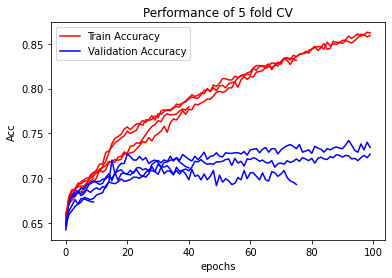

In [30]:
# line plot
plot_epochs(K, lst_train_accuracies, lst_val_accuracies)

In [31]:
# average validation recall, accuracy and f1 for the best epoch of each fold
N = len(all_data)

if testing == True:     # The data in testing has not been used, so reduce N
    N -= len(lst_test_labels[0])

result_mtrx = calculate_avg_val_performance(K, N, lst_val_accuracies, lst_val_labels, lst_val_predictions)


Best average results - Recall: 0.6635924454461191 accuracy: 0.7178701677607586 f1-score: 0.7038886850997875


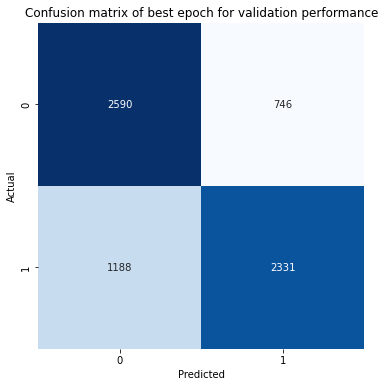

In [32]:
# Confusion matrix for all folds (if testing == true, part 0 is not included here!)
k_fold_confusion_matrix(K, lst_val_accuracies, lst_val_labels, lst_val_predictions)


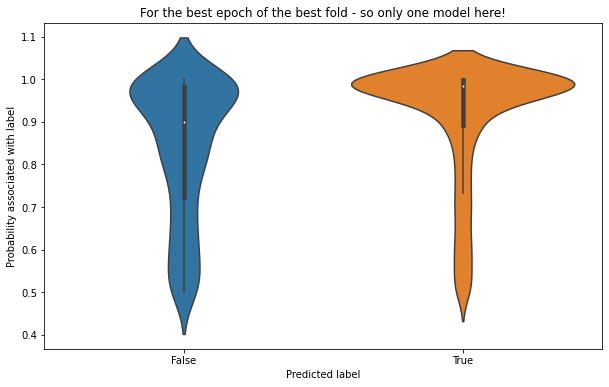

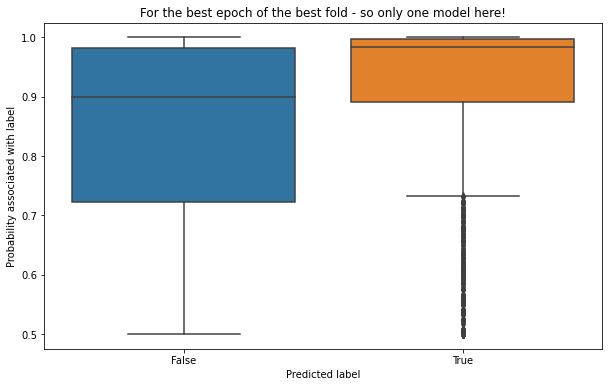

In [33]:
# violin plot
violin_best_fold(result_mtrx, lst_val_accuracies, lst_val_labels, lst_val_predictions, lst_val_probabilities)